导入包

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.filters.hp_filter import hpfilter

plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False   # 防止负号显示问题

加载DR007数据（日度）

In [2]:
df_DR007 = pd.read_csv(r"G:\代码\资产配置项目\Asset-allocation\data\DR007.IB.csv")[:-1]

我们得到DR007的变化率

In [3]:
df_DR007['pct'] = df_DR007['收盘价'].pct_change(fill_method=None)

我们对这个变化率可视化

<Axes: title={'center': 'pct'}, xlabel='日期'>

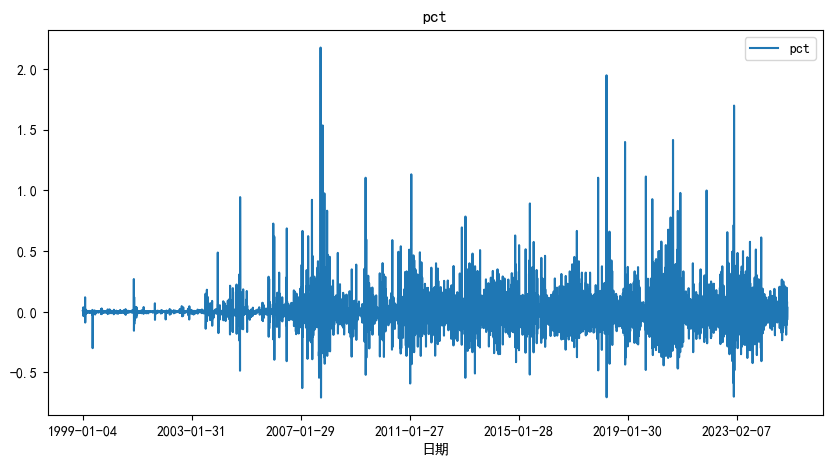

In [4]:
df_DR007.plot(x='日期', y='pct', kind='line', figsize=(10, 5), title='pct')

我们观察到该序列似乎是平稳序列，下面检验一下

In [5]:
from statsmodels.tsa.stattools import adfuller, kpss

def test_stationarity(series):
    adf_result = adfuller(series, autolag='AIC')
    print("ADF 检验结果：")
    print(f"ADF 统计量: {adf_result[0]}")
    print(f"p 值: {adf_result[1]}")
    print(f"临界值: {adf_result[4]}")
    if adf_result[1] < 0.05:
        print("=> 拒绝原假设，时间序列是平稳的。\n")
    else:
        print("=> 无法拒绝原假设，时间序列是非平稳的。\n")

    kpss_result = kpss(series, regression='c', nlags="auto")
    print("KPSS 检验结果：")
    print(f"KPSS 统计量: {kpss_result[0]}")
    print(f"p 值: {kpss_result[1]}")
    print(f"临界值: {kpss_result[3]}")
    if kpss_result[1] < 0.05:
        print("=> 拒绝原假设，时间序列是非平稳的。\n")
    else:
        print("=> 无法拒绝原假设，时间序列是平稳的。\n")

test_stationarity(df_DR007['pct'][1:])

ADF 检验结果：
ADF 统计量: -12.87801901666542
p 值: 4.723775479236157e-24
临界值: {'1%': -3.43136740474287, '5%': -2.8619896048902542, '10%': -2.5670093214398872}
=> 拒绝原假设，时间序列是平稳的。

KPSS 检验结果：
KPSS 统计量: 1.5368248320637226
p 值: 0.01
临界值: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
=> 拒绝原假设，时间序列是非平稳的。



C:\Users\Hosen\AppData\Local\Temp\ipykernel_24792\1453071999.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags="auto")


结果显示，该变化率序列平稳性很好；我们对其ARIMA建模

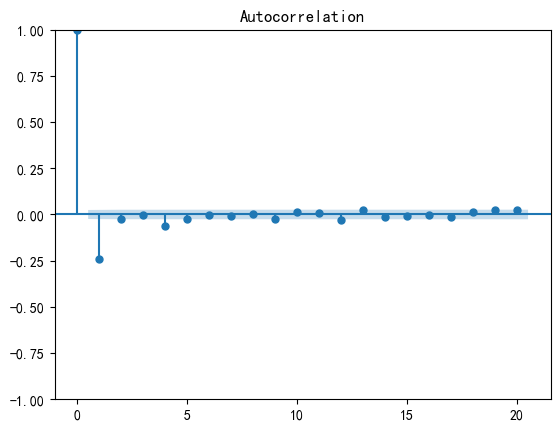

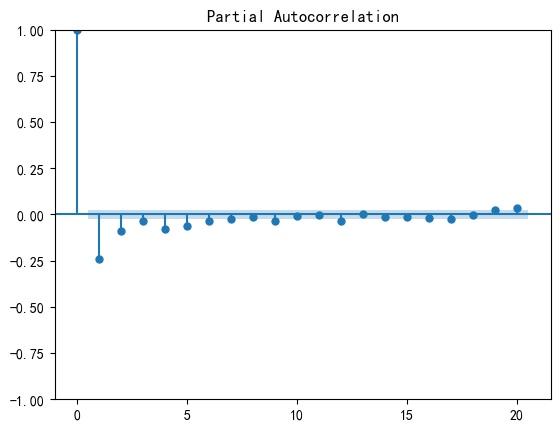

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-7505.080, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-7877.891, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-7930.717, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-7948.652, Time=0.29 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-7968.587, Time=0.54 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-7922.299, Time=0.31 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-7966.796, Time=0.62 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-7966.687, Time=0.73 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-7966.807, Time=0.55 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-7925.210, Time=0.31 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-7968.466, Time=1.74 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-8044.239, Time=2.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-8009.737, Time=1.13 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-7964.018, Time=1.25 sec
 ARIMA(3,0,1)(0,0,0

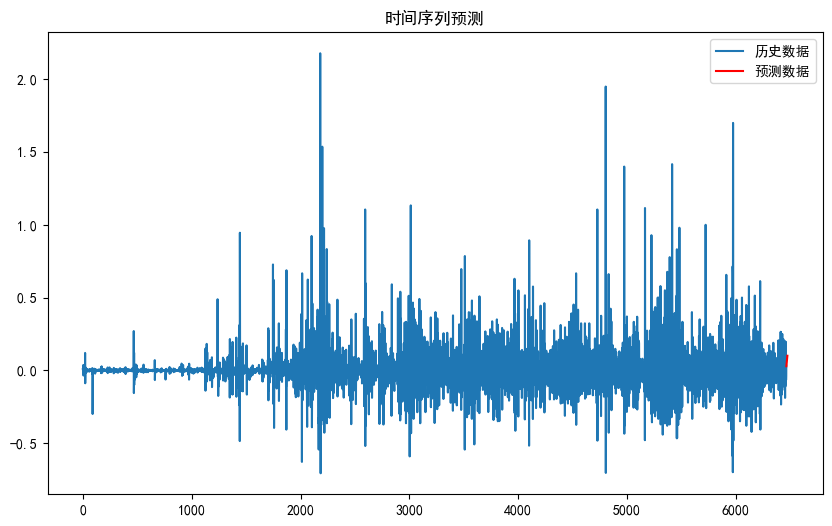

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
import matplotlib.pyplot as plt

r_t = df_DR007['pct'][1:].values

plot_acf(r_t, lags=20)
plot_pacf(r_t, lags=20)
plt.show()

model_r_auto = auto_arima(
    r_t,
    start_p=0,
    start_q=0,
    max_p=5,
    max_q=5,
    d=0, # 已经验证过平稳性，这里不再搜索最优差分阶数，设置为0
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(model_r_auto.summary())

model_r_auto.fit(r_t)

forecast_r_auto = model_r_auto.predict(n_periods=10)

last_original_value = r_t[-1]

forecast_original = [last_original_value]
for diff in forecast_r_auto:
    forecast_original.append(forecast_original[-1] + diff)

forecast_original = forecast_original[1:]

plt.figure(figsize=(10, 6))
plt.plot(r_t, label="历史数据")
plt.plot(range(len(r_t), len(r_t) + len(forecast_original)), forecast_original, label="预测数据", color='red')
plt.legend()
plt.title("时间序列预测")
plt.show()


我们再可视化df_DR007['收盘价']

<Axes: title={'center': 'pct'}, xlabel='日期'>

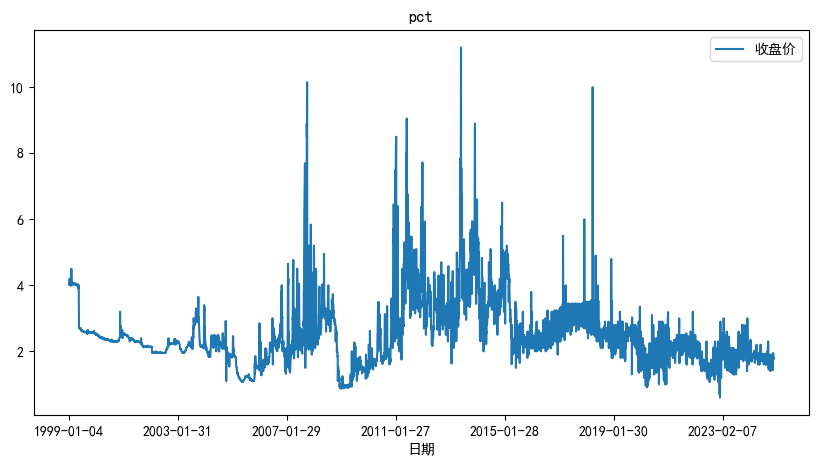

In [7]:
df_DR007.plot(x='日期', y='收盘价', kind='line', figsize=(10, 5), title='pct')

我们同样观察其平稳性

In [8]:
test_stationarity(df_DR007['收盘价'][1:])

ADF 检验结果：
ADF 统计量: -4.686555727958984
p 值: 8.918508479859669e-05
临界值: {'1%': -3.431367563058534, '5%': -2.8619896748401086, '10%': -2.5670093586757545}
=> 拒绝原假设，时间序列是平稳的。

KPSS 检验结果：
KPSS 统计量: 1.0331275165024842
p 值: 0.01
临界值: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
=> 拒绝原假设，时间序列是非平稳的。



C:\Users\Hosen\AppData\Local\Temp\ipykernel_24792\1453071999.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags="auto")


我们发现ADF和KPSS检验出现了矛盾，这说明序列本身可能是趋势平稳的，我们用HP滤波来提取趋势成分

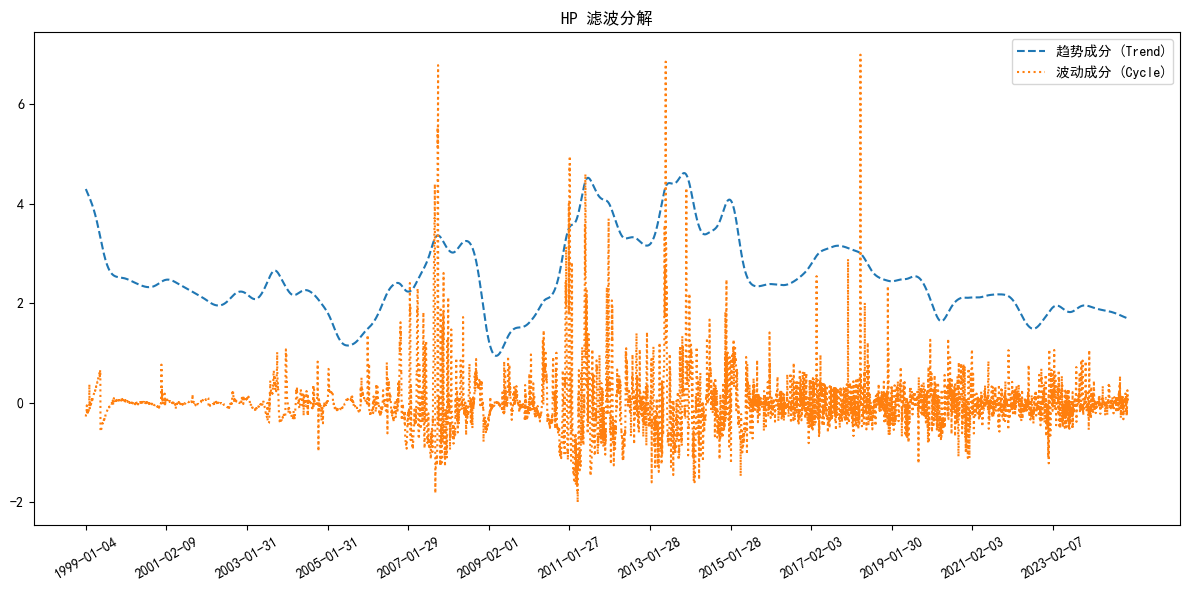

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.filters.hp_filter import hpfilter

cycle, trend = hpfilter(df_DR007['收盘价'], lamb=10**6)

plt.figure(figsize=(12, 6))
plt.plot(df_DR007['日期'], trend, '--', label="趋势成分 (Trend)")
plt.plot(df_DR007['日期'], cycle, ':', label="波动成分 (Cycle)")

ticks_to_use = df_DR007['日期'][::500]
plt.xticks(ticks_to_use, rotation=30)  

plt.legend()
plt.title("HP 滤波分解")
plt.tight_layout()  
plt.show()

我们提取其波峰和波谷，并设定阈值为20%：只有当高（低）点相对于波谷（峰）变化幅度超过该阈值，才成为波峰（谷）

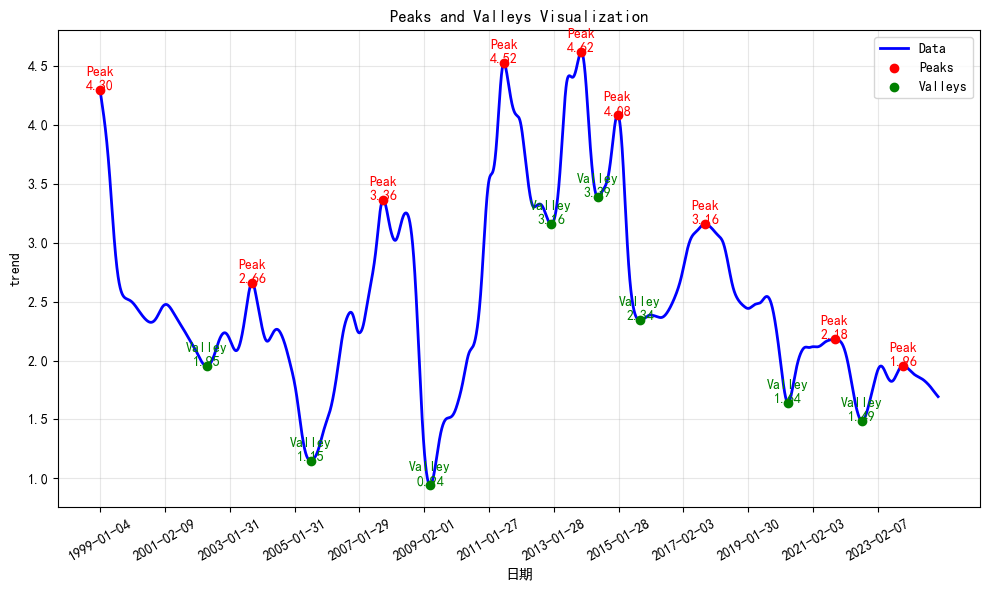

In [11]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def mark_peaks_and_valleys(df, column, peak_threshold=0.1, valley_threshold=0.1):
    data = df[column].values
    peaks, _ = find_peaks(data)
    valleys, _ = find_peaks(-data)
    labels = ['' for _ in range(len(data))]
    peak_points = [{'index': idx, 'type': 'Peak', 'value': data[idx]} for idx in peaks]
    valley_points = [{'index': idx, 'type': 'Valley', 'value': data[idx]} for idx in valleys]
    all_points = peak_points + valley_points
    all_points.sort(key=lambda x: x['index'])
    significant_points = []
    last_point = None
    for point in all_points:
        if last_point is None:
            significant_points.append(point)
            last_point = point
        else:
            if point['type'] != last_point['type']:
                if point['type'] == 'Peak':
                    if point['value'] >= last_point['value'] * (1 + peak_threshold):
                        significant_points.append(point)
                        last_point = point
                else:
                    if point['value'] <= last_point['value'] * (1 - valley_threshold):
                        significant_points.append(point)
                        last_point = point
            else:
                if point['type'] == 'Peak':
                    if point['value'] > last_point['value']:
                        significant_points[-1] = point
                        last_point = point
                else:
                    if point['value'] < last_point['value']:
                        significant_points[-1] = point
                        last_point = point
    if len(significant_points) > 0:
        first_point = significant_points[0]
        if first_point['index'] > 0:
            first_point = {'index': 0, 'type': 'Peak' if data[0] > data[1] else 'Valley', 'value': data[0]}
            significant_points.insert(0, first_point)
    for point in significant_points:
        labels[point['index']] = point['type']
    df['Label'] = labels
    return df

def plot_peaks_and_valleys(df, column):
    data = df[column]
    peaks = df[df['Label'] == 'Peak'].index
    valleys = df[df['Label'] == 'Valley'].index
    plt.figure(figsize=(10, 6))
    plt.plot(df['日期'], data, label='Data', color='blue', linewidth=2)
    plt.scatter(df.loc[peaks, '日期'], data[peaks], color='red', label='Peaks', zorder=5)
    for peak in peaks:
        plt.text(df.loc[peak, '日期'], data[peak], f"Peak\n{data[peak]:.2f}", color='red', ha='center', fontsize=10)
    plt.scatter(df.loc[valleys, '日期'], data[valleys], color='green', label='Valleys', zorder=5)
    for valley in valleys:
        plt.text(df.loc[valley, '日期'], data[valley], f"Valley\n{data[valley]:.2f}", color='green', ha='center', fontsize=10)
    ticks_to_use = df['日期'][::500]
    plt.xticks(ticks_to_use, rotation=30)
    plt.legend()
    plt.title('Peaks and Valleys Visualization')
    plt.xlabel('日期')
    plt.ylabel(column)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

df_DR007['trend'] = trend
result_df = mark_peaks_and_valleys(df_DR007, 'trend', peak_threshold=0.2, valley_threshold=0.2)
plot_peaks_and_valleys(result_df, 'trend')

我们观察到共有16个区间，下面查看每个区间的时间范围，以及其长度

In [22]:
peaks_dates = df_DR007[df_DR007['Label'] == 'Peak']['日期'].reset_index(drop=True)
valleys_dates = df_DR007[df_DR007['Label'] == 'Valley']['日期'].reset_index(drop=True)

periods = []
i, j = 0, 0
while i < len(peaks_dates) or j < len(valleys_dates):
    if j < len(valleys_dates) and (i >= len(peaks_dates) or valleys_dates[j] < peaks_dates[i]):
        if i > 0:  
            periods.append({
                'start_date': peaks_dates[i-1],
                'end_date': valleys_dates[j],
                '周期类型': '宽货币'
            })
        j += 1
    elif i < len(peaks_dates):
        if j > 0:  
            periods.append({
                'start_date': valleys_dates[j-1],
                'end_date': peaks_dates[i],
                '周期类型': '紧货币'
            })
        i += 1

periods_df = pd.DataFrame(periods)

periods_df['start_date'] = pd.to_datetime(periods_df['start_date'])
periods_df['end_date'] = pd.to_datetime(periods_df['end_date'])

periods_df['持续时间（月）'] = (periods_df['end_date'].dt.year - periods_df['start_date'].dt.year) * 12 + \
                                (periods_df['end_date'].dt.month - periods_df['start_date'].dt.month)

periods_df

,start_date,end_date,周期类型,持续时间（月）
0,1999-01-04,2002-05-22,宽货币,40
1,2002-05-22,2003-10-15,紧货币,17
2,2003-10-15,2005-07-29,宽货币,21
3,2005-07-29,2007-10-25,紧货币,27
4,2007-10-25,2009-04-03,宽货币,18
5,2009-04-03,2011-07-15,紧货币,27
6,2011-07-15,2012-12-28,宽货币,17
7,2012-12-28,2013-12-04,紧货币,12
8,2013-12-04,2014-06-11,宽货币,6
9,2014-06-11,2015-01-16,紧货币,7
